In [44]:
words = open('swedish_names.txt', 'r', encoding='utf-8').read().splitlines()
#words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
#words = [w.lower() for w in words if len(w) > 2] # Remove 2< longs words
#words = [w for w in words if w.isascii() and w.isalpha()] # Remove names with åäö or that contains bad things
#words = [w for w in words if '.' not in w]
print(words[-3:])
print(len(words))

['Åsa', 'Åse', 'Ängla']
16626


In [45]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse
print(num_of_unique_letters)
print(letters)
itos

84
[' ', "'", '-', '.', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'Ä', 'Å', 'É', 'Ó', 'Ö', 'Ø', 'Ü', 'à', 'á', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ë', 'í', 'ï', 'ó', 'ô', 'ö', 'ø', 'ú', 'ü']


{1: ' ',
 2: "'",
 3: '-',
 0: '.',
 5: ':',
 6: 'A',
 7: 'B',
 8: 'C',
 9: 'D',
 10: 'E',
 11: 'F',
 12: 'G',
 13: 'H',
 14: 'I',
 15: 'J',
 16: 'K',
 17: 'L',
 18: 'M',
 19: 'N',
 20: 'O',
 21: 'P',
 22: 'Q',
 23: 'R',
 24: 'S',
 25: 'T',
 26: 'U',
 27: 'V',
 28: 'W',
 29: 'X',
 30: 'Y',
 31: 'Z',
 32: 'a',
 33: 'b',
 34: 'c',
 35: 'd',
 36: 'e',
 37: 'f',
 38: 'g',
 39: 'h',
 40: 'i',
 41: 'j',
 42: 'k',
 43: 'l',
 44: 'm',
 45: 'n',
 46: 'o',
 47: 'p',
 48: 'q',
 49: 'r',
 50: 's',
 51: 't',
 52: 'u',
 53: 'v',
 54: 'w',
 55: 'x',
 56: 'y',
 57: 'z',
 58: 'Á',
 59: 'Ä',
 60: 'Å',
 61: 'É',
 62: 'Ó',
 63: 'Ö',
 64: 'Ø',
 65: 'Ü',
 66: 'à',
 67: 'á',
 68: 'ã',
 69: 'ä',
 70: 'å',
 71: 'æ',
 72: 'ç',
 73: 'è',
 74: 'é',
 75: 'ë',
 76: 'í',
 77: 'ï',
 78: 'ó',
 79: 'ô',
 80: 'ö',
 81: 'ø',
 82: 'ú',
 83: 'ü'}

In [46]:
def build_data(words, nChars):
    x, y = [], []
    for w in words:
        chs = list('.'*nChars + w + ".")
        chs = [stoi[c] for c in chs]
        for i in range(len(chs)-nChars):
            x.append(chs[i:i+nChars])
            y.append(chs[i+nChars])
    return (x,y)

# Example 'zuzanna' becomes training example (.. -> z, ..z -> u, and so on until last nna -> .) and chars are converted to the ints

nChars = 3
print(words[-1:])
print(build_data(words[-1:], nChars))


['Ängla']
([[0, 0, 0], [0, 0, 59], [0, 59, 45], [59, 45, 38], [45, 38, 43], [38, 43, 32]], [59, 45, 38, 43, 32, 0])


In [47]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'NVIDIA GeForce RTX 3070 Ti'

In [48]:
random.seed(3)
random.shuffle(words)
trainIdx = int(0.8*len(words))
valIdx = int(0.9*len(words))

xTrain, yTrain = build_data(words[0:trainIdx], nChars)
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)

xVal, yVal = build_data(words[trainIdx:valIdx], nChars)
xVal = torch.tensor(xVal)
yVal = torch.tensor(yVal)

xTest, yTest = build_data(words[valIdx:], nChars)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)

In [49]:
g = torch.Generator().manual_seed(2147483647)

nC = 10 # Look up table, can also be seen as the first layer to our network
nHiddenN = 200 # Size of hidden layer

C = torch.randn((num_of_unique_letters, nC), generator=g)
W1 = torch.randn((nC * nChars, nHiddenN), generator=g)
b1 = torch.randn(nHiddenN, generator=g)
W2 = torch.randn((nHiddenN, num_of_unique_letters), generator=g)
b2 = torch.randn(num_of_unique_letters, generator=g)

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))
trL = []
teL = []

23924


We could also add some search for the best hyper parameters but after testing a few different combinations it seems the architecture of the network is more important to improve on.

      0 / 200000: 33.3045
  10000 / 200000: 2.1816
  20000 / 200000: 2.2105
  30000 / 200000: 2.5967
  40000 / 200000: 3.1305
  50000 / 200000: 2.4381
  60000 / 200000: 2.2784
  70000 / 200000: 2.3638
  80000 / 200000: 2.2276
  90000 / 200000: 2.2848
 100000 / 200000: 2.7435
 110000 / 200000: 2.3230
 120000 / 200000: 2.6652
 130000 / 200000: 2.0514
 140000 / 200000: 2.2935
 150000 / 200000: 2.2170
 160000 / 200000: 1.6502
 170000 / 200000: 1.8894
 180000 / 200000: 2.1204
 190000 / 200000: 2.2467


IndexError: list index out of range

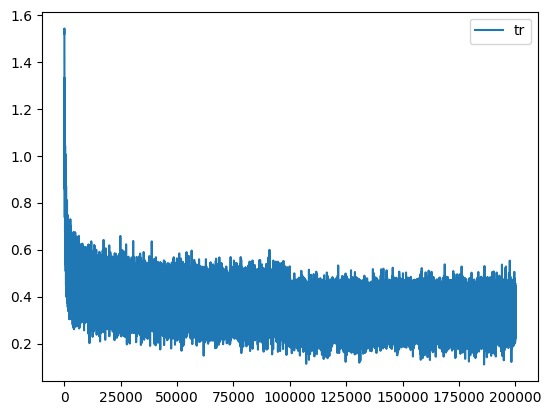

In [50]:
iters = 200000
lr = 0.1
batch_size = 32

for i in range(iters):
    # Get mini batch idx
    mIdx = torch.randint(0, xTrain.shape[0], (batch_size,))
    
    # Forward
    emb = C[xTrain[mIdx]]
    h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                      # in order to have them ass input to our network
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yTrain[mIdx])
    trL.append(loss.log10().item())
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d} /{iters:7d}: {loss.item():.4f}')

plt.plot([i for i in range(len(trL))], trL, label='tr')
plt.legend()
print(f'Last tr loss: {10**trL[-1]}')

In [51]:
# Calulate test loss
emb = C[xTest]
h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                  # in order to have them ass input to our network
logits = h @ W2 + b2
F.cross_entropy(logits, yTest).item()

2.279772996902466

Of course these losses cannot be directly compared to the previous work in the "Simple counts and NN.ipynb" but by looking at the names we produce can at least compare them without human interpretations.

In [52]:
for i in range(10):
    out = []
    context = [stoi[c] for c in list('.'*nChars)]
    while True:
        # Forward
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                          # in order to have them ass input to our network
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

Husen.
Tate.
Avdutaz.
Lek.
Kjell.
Kamoneo.
Berto.
Ansonnidcard.
Carios.
Sebinabibert-Rkeg.


As we can see this method produces better names than our first attempt of both Simple counts and NN with only 1 nC and character encoding into more dimensions (instead of just numbers).

In [24]:
if nC == 2:
    # visualize dimensions 0 and 1 of the embedding matrix C for all characters
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    print(itos)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')
else:
    print("Cant visualize with more than 2 dims")

Cant visualize with more than 2 dims
